In [107]:
import sidechainnet as scn
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sidechainnet.dataloaders.SCNProtein import atom_name_pprint
from sidechainnet.utils.openmm import OpenMMEnergy, OpenMMEnergyH
from sidechainnet.tests.test_hydrogens import load_p, get_alias

from torch.autograd import gradcheck
from torch.autograd.functional import jacobian as get_jacobian
torch.autograd.set_detect_anomaly(True)
torch.set_printoptions(sci_mode=False, precision=3)
np.set_printoptions(precision=3)
torch.cuda.current_device(), torch.cuda.is_available()

(0, True)

In [108]:
d = scn.load("debug",  scn_dataset=True)
p = d['70#4MMO_1_A']

SidechainNet was loaded from ./sidechainnet_data/sidechainnet_debug.pkl.


In [109]:
p.to_3Dmol()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [110]:
from sidechainnet.structure import StructureBuilder

In [111]:
sb = StructureBuilder(p.seq, ang=p.angles,device=p.device)

In [112]:
p.seq

'MDEELYTLIEFLKKPSISATGEGIDETANYLKETVEKLLGVKANLEKTKGHPVVYAEINVNAKKTLLIYNHYDVQPVDPISEWKRAPFSATIENDRIYARGASDNKGTLMARLFAIKHLLDKNELNVNVKLLYEGEEEIGSVNLEDYIEKNTNKLKADSVIMEGAGLDPKGRPQIVLGVKGLLYVELVLDYGTKDLHSSNAPLVRNPCIDLAKIISTLVDMGGRVLIEGFYDDVRELTEEERELIKKYDIDVEELKKALGFKELKYNEKEKIAEALLTYPTCNVDGFECGYTGKGSKTIVPHRAFAKLDFRLVPNQDPYKVFELLKKHLQKAGFNGEILAHGFEYPVRTSVNSTVVKAMIESAKKVYGTEPQVIPNSAGTQPMGLFVYKLGIRDAVSAIGAGGYYSNAHAPNENIKIDDYYKAIKHTEEFLKLYPIL'

In [113]:
from sidechainnet.structure.build_info import SC_BUILD_INFO, BB_BUILD_INFO, NUM_COORDS_PER_RES, SC_ANGLES_START_POS, NUM_ANGLES


In [114]:
BB_BUILD_INFO

{'BONDLENS': {'n-ca': 1.442,
  'ca-c': 1.498,
  'c-n': 1.379,
  'c-o': 1.229,
  'c-oh': 1.364},
 'BONDANGS': {'ca-c-o': 2.0944, 'ca-c-oh': 2.0944},
 'BONDTORSIONS': {'n-ca-c-n': -0.785398163}}

In [115]:
import torch

In [116]:
def makeTmats(N, ctheta, stheta, cchi, schi, lens, device):
    '''Make transformation matrices given angles/lens '''
    mats = torch.zeros((N,4,4),device=device)

    mats[:,0,0] = ctheta
    mats[:,0,1] = -stheta
    mats[:,0,3] = ctheta*lens

    mats[:,1,0] = cchi*stheta
    mats[:,1,1] = ctheta*cchi
    mats[:,1,2] = schi
    mats[:,1,3] = cchi*lens*stheta

    mats[:,2,0] = -stheta*schi
    mats[:,2,1] = -ctheta*schi
    mats[:,2,2] = cchi
    mats[:,2,3] = -lens*stheta*schi

    mats[:,3,3] = 1.0
    
    return mats

In [117]:
aa = np.array(['A','C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])
num2aa = {i:a for i,a in enumerate(aa)}
aa2num = {a:i for i,a in enumerate(aa)}

In [118]:
aa3to1 = {'ALA':'A','ARG':'R','ASN':'N','ASP':'D','CYS':'C','GLN':'Q','GLU':'E','GLY':'G','HIS':'H','ILE':'I',
          'LEU':'L','LYS':'K','MET':'M','PHE':'F','PRO':'P','SER':'S','THR':'T','TRP':'W','TYR':'Y','VAL':'V'}
aa1to3 = {v:k for (k,v) in aa3to1.items()}

For every sidechain atom need to know what atom it is building off of (<NUM_COORDS_PER_RES=14), the bond length, the theta bond angle, and the chi torsion angle.  For atoms where the torsion angles are inputs, need to specify angle source index (>=SC_ANGLES_START_POS=6, <NUM_ANGLES=12).

Zero is start of sidechain atoms/angles.

In [119]:
for r in sorted(SC_BUILD_INFO.keys()):
    print('    {"%s", {'%r)
    for k in sorted(SC_BUILD_INFO[r].keys()):
        if len(SC_BUILD_INFO[r][k]) == 0 or type(SC_BUILD_INFO[r][k][0]) == str:
            print('        {',', '.join(map(lambda x: '"%s"'%x,SC_BUILD_INFO[r][k])),'},')
        else:
            print('        {',', '.join(map(lambda x: '%g'%x, SC_BUILD_INFO[r][k])),'},')
    print('    }},')
        

    {"ALA", {
        { "N-CA-CB" },
        { "N -CX-CT" },
        { 1.91463 },
        { "CB" },
        { "CA-CB" },
        { "CX-CT" },
        { 1.526 },
        { "C-N-CA-CB" },
        { "C -N -CX-CT" },
        { "p" },
    }},
    {"ARG", {
        { "N-CA-CB", "CA-CB-CG", "CB-CG-CD", "CG-CD-NE", "CD-NE-CZ", "NE-CZ-NH1", "NE-CZ-NH2" },
        { "N -CX-C8", "CX-C8-C8", "C8-C8-C8", "C8-C8-N2", "C8-N2-CA", "N2-CA-N2", "N2-CA-N2" },
        { 1.91463, 1.91114, 1.91114, 1.94081, 2.15025, 2.0944, 2.0944 },
        { "CB", "CG", "CD", "NE", "CZ", "NH1", "NH2" },
        { "CA-CB", "CB-CG", "CG-CD", "CD-NE", "NE-CZ", "CZ-NH1", "CZ-NH2" },
        { "CX-C8", "C8-C8", "C8-C8", "C8-N2", "N2-CA", "CA-N2", "CA-N2" },
        { 1.526, 1.526, 1.526, 1.463, 1.34, 1.34, 1.34 },
        { "C-N-CA-CB", "N-CA-CB-CG", "CA-CB-CG-CD", "CB-CG-CD-NE", "CG-CD-NE-CZ", "CD-NE-CZ-NH1", "CD-NE-CZ-NH2" },
        { "C -N -CX-C8", "N -CX-C8-C8", "CX-C8-C8-C8", "C8-C8-C8-N2", "C8-C8-N2-CA", "C8-N2-CA-N2", 

In [120]:
SC_BUILD_INFO['GLY']

{'angles-names': [],
 'angles-types': [],
 'angles-vals': [],
 'atom-names': [],
 'bonds-names': [],
 'bonds-types': [],
 'bonds-vals': [],
 'torsion-names': [],
 'torsion-types': [],
 'torsion-vals': []}

In [121]:
type(SC_BUILD_INFO[r][k][0]) == str

True

In [122]:
N = NUM_COORDS_PER_RES-4
sc_source_atom = torch.zeros(20,N)
sc_bond_length =  torch.zeros(20,N)
sc_ctheta =  torch.zeros(20,N)
sc_stheta =  torch.zeros(20,N)
sc_cchi =  torch.zeros(20,N)
sc_schi =  torch.zeros(20,N)
sc_type =  torch.zeros(20,N) # 0: no atom, 1: regular torsion, 2: offset torsion, 3: constant
#index of chi is same as atom index, unless offset torsion in which case it is one before

for a in range(20):
    A = aa[a]
    a3 = aa1to3[A]
    info = SC_BUILD_INFO[a3]
    for i in range(NUM_COORDS_PER_RES-4):
        if i < len(info['torsion-vals']):
            sc_bond_length[a][i] = info['bonds-vals'][i]
            sc_ctheta[a][i] = np.cos(np.pi-info['angles-vals'][i])
            sc_stheta[a][i] = np.sin(np.pi-info['angles-vals'][i])
            
            t = info['torsion-vals'][i]
            if t == 'p':
                sc_type[a][i] = 1
            elif t == 'i':
                sc_type[a][i] = 2
            else:
                sc_type[a][i] = 3
                sc_cchi[a][i] = np.cos(2*np.pi-t)
                sc_schi[a][i] = np.sin(2*np.pi-t)
                
            src = info['bonds-names'][i].split('-')[0]
            if src != 'CA':
                sc_source_atom[a][i] = info['atom-names'].index(src)
            else:
                sc_source_atom[a][i] = -1
            

In [123]:
seq = np.array(list(p.seq))

Note that coordinates for first few residues will be off because angles are relative to different atoms.

In [124]:
p.torch()

In [125]:
import time

In [126]:
def make_backbone_serial(ncacM):
    '''Make backbone matrices from individual transformation matrices
    by multiplying in order.  Modifies in-place.'''
    for i in range(1,len(ncacM)):
        ncacM[i] = ncacM[i-1]@ncacM[i]
    return ncacM

In [127]:
def make_backbone(M):
    '''Make backbone matrices from individual transformation matrices using
    log(N) parallel matrix multiplies.  Modifies in place.'''

    N = len(M)
    indices = torch.arange(0,N)

    for i in range(N.bit_length()):
        dstmask = ((1<<i)&indices) != 0
        srci = ((-1<<i)&indices)-1

        src = M[srci[dstmask]]
        dst = M[dstmask]

        M[dstmask] = src@dst
        
    return M

In [128]:
def make_coords(p,device='cpu'):
    '''Create coordinates from p angles using torch operations'''
    t1 = time.time()
    L = len(p.seq)
    ang = torch.zeros((L+1,SC_ANGLES_START_POS),device=device)
    ang[1:] = p.angles.to(device)[:L,:SC_ANGLES_START_POS] 
    ang[:,3:] = np.pi-ang[:,3:] #theta
    ang[:,:3] = 2*np.pi-ang[:,:3] #chi

    sins = torch.sin(ang)
    coss = torch.cos(ang)
    #O needs one additional angle
    schi = sins[:,:3].flatten()[1:-1]
    cchi = coss[:,:3].flatten()[1:-1]

    oschi = schi[3::3]
    occhi = cchi[3::3]
    schi = schi[:-1]
    cchi = cchi[:-1]

    stheta = sins[:,3:].flatten()[1:-2]
    ctheta = coss[:,3:].flatten()[1:-2]

    lens = torch.tensor([BB_BUILD_INFO['BONDLENS']['c-n'],BB_BUILD_INFO['BONDLENS']['n-ca'],BB_BUILD_INFO['BONDLENS']['ca-c']],device=device).repeat(L)
    lens[0] = 0 # first atom starts at origin

    ncacM = makeTmats(L*3, ctheta, stheta, cchi, schi, lens, device)

    t2 = time.time()
    ncacM = make_backbone(ncacM)

    t3 = time.time()
    # =O
    t = torch.tensor(np.pi-BB_BUILD_INFO["BONDANGS"]["ca-c-o"],device=device)
    ct = torch.cos(t)
    st = torch.sin(t)
    l = BB_BUILD_INFO["BONDLENS"]["c-o"]
    Omats = makeTmats(L, ct, st, -occhi, -oschi, l, device)

    oM = ncacM[2::3]@Omats

    vec = torch.tensor([0.0,0,0,1],device=device)
    ncac = (ncacM@vec)[:,:3].reshape(L,3,3)    
    ocoords = (oM@vec)[:,:3].reshape(L,1,3)
    
    
    sccoords = torch.zeros(L,NUM_COORDS_PER_RES-4,3,device=device)

    #all sc angles are dihedrals
    ang = (2*np.pi-p.angles.float().to(device)[:,SC_ANGLES_START_POS:])

    sins = torch.sin(ang)
    coss = torch.cos(ang)

    #convert sequence to aa index
    seq_aa_index = torch.tensor([aa2num[a] for a in p.seq])

    #select out angles/bonds/etc for full seq
    bond_lengths = sc_bond_length[seq_aa_index].to(device) # L x 10
    source_atoms = sc_source_atom[seq_aa_index].to(device)
    cthetas =  sc_ctheta[seq_aa_index].to(device)
    sthetas =  sc_stheta[seq_aa_index].to(device)
    cchis =  sc_cchi[seq_aa_index].to(device)
    schis =  sc_schi[seq_aa_index].to(device)
    types = sc_type[seq_aa_index].to(device)
    sources = sc_source_atom[seq_aa_index].to(device)

    # first iteration: build from CA
    seqmask = types[:,0].bool() #no G

    lens = bond_lengths[seqmask,0]
    N = len(lens)
    ctheta = cthetas[seqmask,0]
    stheta = sthetas[seqmask,0]
    cchi = coss[seqmask,0]
    schi = sins[seqmask,0]

    mats = makeTmats(N, ctheta, stheta, cchi, schi, lens, device)
    prevmats = ncacM[1::3][seqmask]@mats
    c = prevmats@vec
    sccoords[seqmask,0] = c[:,:3]      
    
    matrices = []
    masks = []
    
    t4 = time.time()
    for i in range(1,10):
        matrices.append(prevmats)
        masks.append(seqmask)
        prevmask = seqmask
        
        seqmask = types[:,i].bool() #no G
        lens = bond_lengths[seqmask,i]
        N = len(lens)
        if N == 0:
            break
        #theta always constant
        ctheta = cthetas[seqmask,i]
        stheta = sthetas[seqmask,i]

        #set to constant
        cchi = cchis[seqmask,i]
        schi = schis[seqmask,i]


        #unless not
        regmask = types[:,i] == 1  # regular chi
        if regmask.any():
            cchi[regmask[seqmask]] = coss[regmask,i]
            schi[regmask[seqmask]] = sins[regmask,i]

        invmask = types[:,i] == 2
        if invmask.any():
            cchi[invmask[seqmask]] = -coss[invmask,i-1]
            schi[invmask[seqmask]] = -sins[invmask,i-1]        

        #check if any atoms need matrix from farther back
        if (sources[:,i] != i-1).any():
            prevmats = prevmats.clone()
            
            for k in range(i-2,-1,-1):
                srcmask = (sources[:,i] == k) & seqmask
                if srcmask.any(): #change prevmat to earlier matrix
                    prevmats[srcmask[prevmask]] = matrices[k][srcmask[masks[k]]]
            
            
        mats = makeTmats(N, ctheta, stheta, cchi, schi, lens, device)

        prevmats = prevmats[seqmask[prevmask]]@mats

        c = prevmats@vec
        sccoords[seqmask,i] = c[:,:3]     
        
    t5 = time.time()
    #print("Times",t2-t1,t3-t2,t4-t3,t5-t4)
    return torch.concat([ncac,ocoords,sccoords],dim=1)

In [129]:
genc = make_coords(p)

In [130]:
%%timeit
p.angles.requires_grad = False
genc = make_coords(p)

5.76 ms ± 27.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [131]:
%%timeit
p.angles.requires_grad = True
genc = make_coords(p)

267 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [132]:
%%timeit
p.angles.requires_grad = False
genc = make_coords(p,device='cuda')

18.1 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [133]:
%%timeit
p.angles.requires_grad = True
genc = make_coords(p,device='cuda')

218 ms ± 66.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [187]:
%%time
p.add_hydrogens()

CPU times: user 243 ms, sys: 0 ns, total: 243 ms
Wall time: 241 ms


In [161]:
sb = StructureBuilder(p.seq, ang=p.angles,device=p.device)

In [188]:
sb.build()

tensor([[    0.000,     0.000,     0.001],
        [    1.442,     0.000,     0.001],
        [    1.974,     1.401,     0.001],
        ...,
        [    0.000,     0.000,     0.000],
        [    0.000,     0.000,     0.000],
        [    0.000,     0.000,     0.000]], dtype=torch.float64,
       grad_fn=<ToCopyBackward0>)

In [190]:
%%time
sb.add_hydrogens()

CPU times: user 3.27 s, sys: 273 ms, total: 3.54 s
Wall time: 3.54 s


In [162]:
%%timeit
goodcoords = sb.build()

5.47 s ± 48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [179]:
sb = StructureBuilder(p.seq, ang=p.angles,device=p.device)

In [180]:
sb.build()

tensor([[    0.000,     0.000,     0.001],
        [    1.442,     0.000,     0.001],
        [    1.974,     1.401,     0.001],
        ...,
        [    0.000,     0.000,     0.000],
        [    0.000,     0.000,     0.000],
        [    0.000,     0.000,     0.000]], dtype=torch.float64,
       grad_fn=<ToCopyBackward0>)

In [ ]:
p.

In [136]:
%time
goodcoords  = sb.build()

In [164]:
%time
sb.add_hydrogens()

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 16.7 µs


In [166]:
sb.has_hydrogens

True

In [177]:
%time
p.add_hydrogens(from_angles=True)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 16.9 µs


In [178]:
sb.build(p)

TypeError: build() takes 1 positional argument but 2 were given

In [168]:
help(sb.add_hydrogens)

Help on method add_hydrogens in module sidechainnet.structure.StructureBuilder:

add_hydrogens() method of sidechainnet.structure.StructureBuilder.StructureBuilder instance
    Add Hydrogen atom coordinates to coordinate representation (re-apply PADs).



In [137]:
goodcoords.requires_grad,genc.requires_grad

(True, False)

In [138]:
diff = (genc.cpu()-goodcoords.reshape(genc.shape)).reshape((len(p.seq),-1))

<AxesSubplot:>

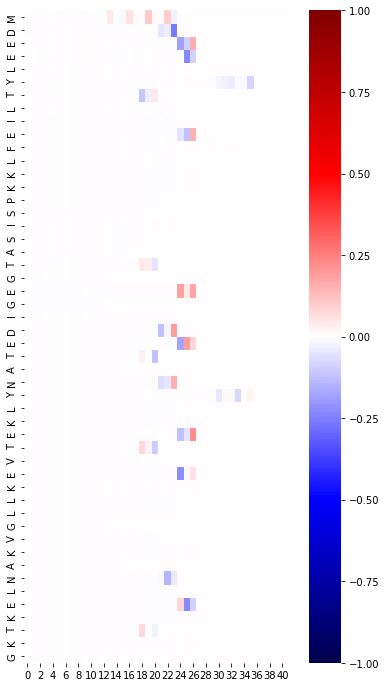

In [139]:
plt.figure(figsize=(6,12))
sns.heatmap(diff.detach().numpy()[:50],yticklabels=p.seq[:50],cmap='seismic',vmin=-1,vmax=1)

In [140]:
import py3Dmol
sb = StructureBuilder(p.seq, ang=p.angles,device=p.device)
origpdb = sb.to_pdbstr()
goodcoords = sb.coords
genc = make_coords(p)
sb.coords = genc.reshape(goodcoords.shape)
sb.pdb_creator = None
genpdb = sb.to_pdbstr()

In [141]:
origpdb == genpdb

False

In [142]:
v = py3Dmol.view(width=1024,height=768,data=origpdb,style={'cartoon':{'color':'spectrum'},'stick':{'colorscheme':'greenCarbon'}})
v.addModel(genpdb)
v.setStyle({'model':1},{'stick':{'radius':.25}})

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [143]:
from torch.utils.cpp_extension import load
fastbuild = load(name="fastbuild", sources=["fastbuild/fastbuild.cpp"],verbose=True)

Using /home/dkoes/.cache/torch_extensions/py38_cu113 as PyTorch extensions root...
No modifications detected for re-loaded extension module fastbuild_v6, skipping build step...
Loading extension module fastbuild_v6...


In [144]:
genc = make_coords(p)

In [145]:
genc2 = fastbuild.make_coords(p.seq,p.angles)

In [146]:
genc.shape

torch.Size([437, 14, 3])

In [147]:
torch.sum(genc2-genc)

tensor(0.001, grad_fn=<SumBackward0>)

In [148]:
%%timeit
p.angles.requires_grad = True
genc = make_coords(p,device='cpu')

163 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [149]:
%%timeit
p.angles.requires_grad = True
genc2 = fastbuild.make_coords(p.seq,p.angles.to('cpu'))

149 ms ± 538 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [150]:
(genc-genc2).sum()

tensor(-0.001, grad_fn=<SumBackward0>)

In [151]:
%%timeit
p.angles.requires_grad = True
genc = make_coords(p,device='cuda')

152 ms ± 712 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [152]:
%%timeit
p.angles.requires_grad = True
genc = fastbuild.make_coords(p.seq,p.angles.to('cuda'))

139 ms ± 483 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [153]:
%%timeit
p.angles.requires_grad = False
genc = make_coords(p,device='cpu')

6.03 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [154]:
%%timeit
p.angles.requires_grad = False
genc = fastbuild.make_coords(p.seq,p.angles.to('cpu'))

5.16 ms ± 149 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Backbone parallelization - will it work?

In [155]:
M = NCAC.clone()

In [156]:
a = make_backbone(M.clone())

In [157]:
b = make_backbone_serial(M.clone())

In [158]:
torch.sum(a-b)

tensor(0.028)